__Классификация аудиоданных.__ 

Евгений Борисов esborisov@sevsu.ru


----

Understand Audio data.   
https://www.geeksforgeeks.org/understand-audio-data/

Классификация аудиофайлов с библиотекой Librosa.     
https://habr.com/ru/companies/otus/articles/741080/

Music Information Retrieval    
https://musicinformationretrieval.com

Understanding Origins and Fusion of Music Genres     
https://shouvikmani.github.io/Million-Song-Dataset-Visualization/index.html

In [1]:
# !pip install scipy==1.12.0 matplotlib==3.7.1 librosa

## загружаем данные 

George Tzanetakis, Georg Essl, Perry Cook    Automatic Musical Genre Classification Of Audio Signals.   
https://ismir2001.ismir.net/pdf/tzanetakis.pdf   

Raw data is 1.2GB and consists of 1000 audio files(.au) divided into 10 folders for 10 genres equally. I.e Every genre has 100 audio files.

http://opihi.cs.uvic.ca/sound/genres.tar.gz

https://zdataset.com/free-dataset/gtzan-dataset-music-genre-classification/

https://drive.google.com/drive/folders/189jIlfQ-E94eHfKVksbAUSXKX68Ju1GI

In [2]:
data_folder = 'data/GTZAN_Dataset-Music_Genre_Classification/genres_original'

In [3]:
import os
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

In [4]:
files = pd.DataFrame([ 
        { 
            'file':os.listdir(os.path.join(data_folder,genre)), 
            'genre': genre, 
        } 
        for genre in os.listdir(data_folder)
    ]).explode('file').reset_index(drop=True)

display( len(files) )
display( files.sample(5) )

1000

,file,genre
659,blues.00029.wav,blues
553,disco.00090.wav,disco
239,jazz.00033.wav,jazz
579,disco.00084.wav,disco
132,classical.00059.wav,classical


In [5]:
# 'jazz/jazz.00054.wav': Format not recognised.
files = files[ ~files['file'].isin(['jazz.00054.wav']) ].reset_index(drop=True) 

In [6]:
# files = files.sample(256).reset_index(drop=True)
# files.groupby('genre').count()

# признаки в аудиоданных

In [7]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt

In [8]:
# from pydub import AudioSegment
from IPython.display import Audio

In [9]:
import librosa as lrs
from librosa.display import waveshow
from librosa.display import specshow
from librosa import feature

In [10]:
# lrs.version.show_versions()

In [15]:
n_sample = rng.randint(len(files))
fpath = os.path.join( *[ data_folder ] + files.iloc[n_sample][['genre','file']].tolist() )
display(fpath)

data, rate = lrs.load(fpath)
display(data.shape)

'data/GTZAN_Dataset-Music_Genre_Classification/genres_original/disco/disco.00007.wav'

(661794,)

In [16]:
rate

22050

In [17]:
print( f'Duration: { lrs.get_duration(y=data,sr=rate):.2f} sec' )

print(f'Sample Rate: {rate}')

# Compute the amplitude range
amplitude_range = np.max(data) - np.min(data)
print(f'Amplitude Range: {amplitude_range}')

# Get the bit depth from the audio data
bit_depth = data.dtype.itemsize
# printing values
print(f'Bit Depth: {bit_depth} bits')

Duration: 30.01 sec
Sample Rate: 22050
Amplitude Range: 1.930023193359375
Bit Depth: 4 bits


In [18]:
Audio(data=data,rate=rate,autoplay=False)

Text(0.5, 1.0, 'data/GTZAN_Dataset-Music_Genre_Classification/genres_original/disco/disco.00007.wav')

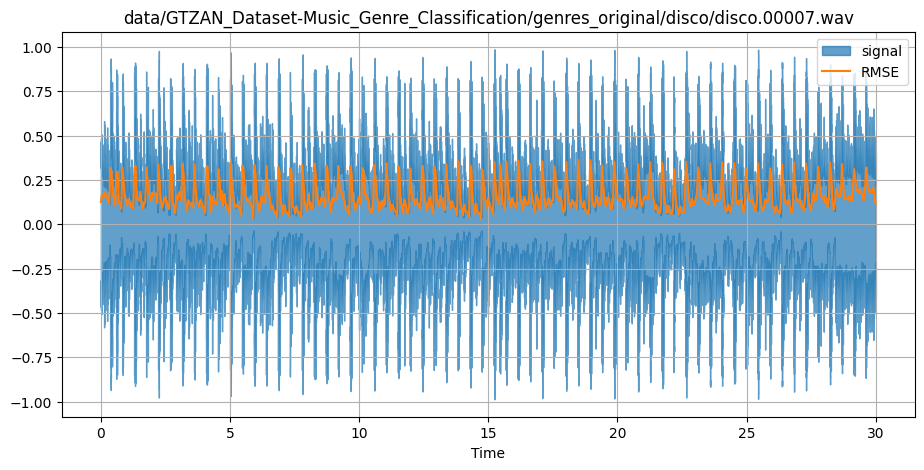

In [19]:
# Root-mean square energy

data_rms = feature.rms(y=data, frame_length=1024, hop_length=1024)[0]
t = lrs.times_like(data_rms, hop_length=1024, sr=rate)

fig,ax = plt.subplots(figsize=(11, 5))
waveshow(y=data, sr=rate, alpha=.7, ax=ax, label='signal')
ax.plot( t, data_rms, label='RMSE' )
ax.grid()
ax.legend()
ax.set_title(fpath)

In [21]:
tempo, beat_frames = lrs.beat.beat_track(y=data, sr=rate)
# print(f'Estimated tempo: {tempo:.2f} beats per minute')
print(f'Estimated tempo: {tempo} beats per minute')

Estimated tempo: [129.19921875] beats per minute


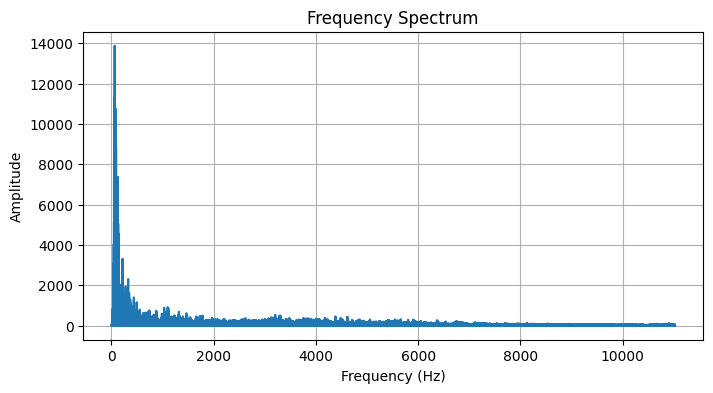

In [22]:
from scipy.fft import fft

# Compute the FFT of the waveform
spectrum = fft(data)
 
# Frequency bins
frequencies = np.fft.fftfreq(len(spectrum), 1 / rate)
 
# Plot the frequency spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(spectrum[:len(spectrum)//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum')
plt.grid(True)
plt.show()


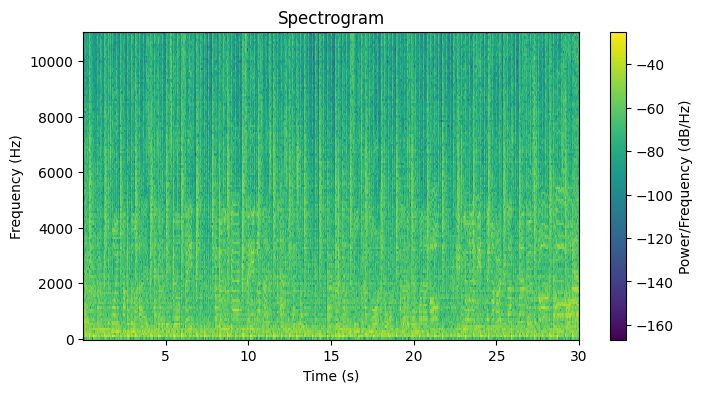

In [23]:
# Compute the spectrogram
from scipy.signal import spectrogram
    
# Small constant to avoid division by zero(if any)
epsilon = 1e-40 
f, t, Sxx = spectrogram(data, fs=rate)
 
# Plot the spectrogram with the constant added to Sxx
plt.figure(figsize=(8, 4))
plt.pcolormesh(t, f, 10 * np.log10(Sxx + epsilon))
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.show()


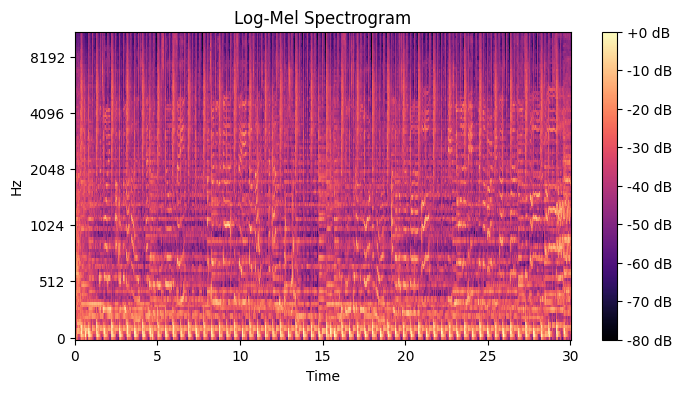

In [24]:
# visualizing log-mel spectrogram
def compute_logmel_spectrogram(y, sr, n_mels=128, hop_length=512):
    mel_spectrogram = feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel_spectrogram = lrs.power_to_db(mel_spectrogram, ref=np.max)
    return logmel_spectrogram

# Compute log-mel spectrogram
logmel_spectrogram = compute_logmel_spectrogram(data, sr=rate)
 
# Display the log-mel spectrogram
plt.figure(figsize=(8, 4))
specshow(logmel_spectrogram, sr=rate, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.show()

In [ ]:
# feature.zero_crossing_rate(data).shape

In [ ]:
# # zc = lrs.zero_crossings(data)
# zrate = feature.zero_crossing_rate(data)
# fig,ax = plt.subplots(figsize=(11, 5))
# ax.semilogy(zrate.T, label='Fraction')
# #ax.plot(zrate.T, label='Fraction')
# ax.set_ylabel('Fraction per Frame')
# ax.grid()
# ax.legend()

In [ ]:
# data_rms = feature.rms(y=data, frame_length=1024, hop_length=1024)[0]
# feature.rms(y=data).shape

In [ ]:
# feature.spectral_centroid(y=data, sr=rate).shape

In [ ]:
# feature.spectral_rolloff(y=data, sr=rate)

In [ ]:
# feature.chroma_stft(y=data, sr=rate).shape

In [ ]:
# feature.spectral_bandwidth(y=data, sr=rate).std()

In [ ]:
# feature.tonnetz(y=data, sr=rate).shape

In [ ]:
# plt.plot( data, alpha=0.7 )
# plt.plot( lrs.effects.harmonic(data) )

In [ ]:
# C = np.abs(lrs.cqt(y=data, sr=rate, fmin=lrs.note_to_hz('A1')))
# freqs = lrs.cqt_frequencies(C.shape[0],fmin=lrs.note_to_hz('A1'))
# perceptual_CQT = librosa.perceptual_weighting(C**2,freqs, ref=np.max)

# формируем датасет

In [25]:
%%time

def music_features(fpath):
    data, rate = lrs.load(fpath)
        
    tempo, _ = lrs.beat.beat_track(y=data, sr=rate)
    zc = feature.zero_crossing_rate(data)
    rms = feature.rms(y=data)
    cent = feature.spectral_centroid(y=data, sr=rate)
    rolloff = feature.spectral_rolloff(y=data, sr=rate)
    cstft = feature.chroma_stft(y=data, sr=rate)
    sbandwidth = feature.spectral_bandwidth(y=data, sr=rate)
    # mfcc = [ feature.mfcc(y=data,sr=rate,n_mels=n) for n in range(10,21,5) ]
    mfcc = [ feature.mfcc(y=data,sr=rate) ]
    tonnetz = feature.tonnetz(y=data, sr=rate)
    # harmonic = lrs.effects.harmonic(data)
    
    return np.hstack([
        zc.mean(),zc.std(),
        rms.mean(),rms.std(),
        tempo,
        cent.mean(),cent.std(),
        rolloff.mean(),rolloff.std(),
        cstft.mean(axis=1),cstft.std(axis=1),
        sbandwidth.mean(axis=1),sbandwidth.std(axis=1),
        tonnetz.mean(axis=1),tonnetz.std(axis=1),
        # harmonic.mean(),harmonic.std(),
        ] 
        + [ m.mean(axis=1) for m in mfcc ] + [ m.std(axis=1) for m in mfcc ]
        
    )

x = np.vstack(
        files.apply(
            lambda r: os.path.join( *[ data_folder ] + r[['genre','file']].tolist() ),
            axis=1
        ).progress_apply(music_features)
    )

display(x.shape)

  0%|          | 0/999 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
labels = { g:n for n,g in enumerate(sorted(set(files['genre']))) } 
target = files['genre'].map(labels).values

----

In [27]:
import pandas as pd

df = pd.read_csv(
        'data/GTZAN_Dataset-Music_Genre_Classification/features_30_sec.csv.gz'
    ).convert_dtypes()

x = df.drop(columns=['filename','length','label']).values

labels = { g:n for n,g in enumerate(sorted(set(df['label']))) } 
target = df['label'].map(labels).values

display( x.shape,target.shape )


(1000, 57)

(1000,)

In [28]:
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.16585,129774.064525,2002.44906,85882.761315,...,52.42091,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.09498,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.10619,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.17557,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.43972,46.63966,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.31913,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.19516,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.70951,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.01004,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.96804,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.00111,-12.58807,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.08386,0.001211,1398.699344,240318.731073,1818.45028,109090.207161,...,46.324894,-4.41605,43.583942,1.556207,34.331261,-5.041897,47.22718,-3.590644,41.299088,rock


----

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, target_train, target_test = train_test_split(x,target,test_size=.3)
display( x_train.shape, target_train.shape, x_test.shape, target_test.shape )

(700, 57)

(700,)

(300, 57)

(300,)

# обучаем классификатор

In [30]:
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier().fit(x_train,target_train)

In [31]:
# o_train = model.predict(x_train)
# o_test = model.predict(x_test)

---

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_ = scaler.transform(x_train)
x_test_ = scaler.transform(x_test)

In [43]:
# from xgboost import XGBClassifier
# model = XGBClassifier(n_estimators=1024).fit(x_train,target_train)

In [44]:
# from sklearn.linear_model import SGDClassifier
# model = SGDClassifier().fit(x_train,target_train)

In [49]:
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression().fit(x_train_,target_train)

In [50]:
# from sklearn.neural_network import MLPClassifier
# model = MLPClassifier(
#         hidden_layer_sizes=(1024*2,10)
#         #solver='lbfgs', alpha=1e-5, , random_state=1
#     ).fit(x_train_,target_train)

In [51]:
o_train = model.predict(x_train_)
o_test = model.predict(x_test_)

# результаты

In [52]:
from sklearn.metrics import accuracy_score

# доля правильных ответов на учебном наборе
display( accuracy_score(target_train,o_train) )

# доля правильных ответов на тестовом наборе
display(  accuracy_score(target_test,o_test) )

0.9014285714285715

0.71

In [53]:
from sklearn.metrics import classification_report

print( classification_report( target_test, o_test, target_names=sorted(labels.keys()) ) )

              precision    recall  f1-score   support

       blues       0.61      0.71      0.65        24
   classical       0.94      0.94      0.94        33
     country       0.72      0.72      0.72        29
       disco       0.61      0.56      0.58        25
      hiphop       0.69      0.71      0.70        35
        jazz       0.76      0.76      0.76        25
       metal       0.73      0.85      0.79        26
         pop       0.96      0.65      0.78        40
      reggae       0.53      0.67      0.59        30
        rock       0.58      0.55      0.56        33

    accuracy                           0.71       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.73      0.71      0.71       300



In [54]:
from matplotlib import pyplot as plt

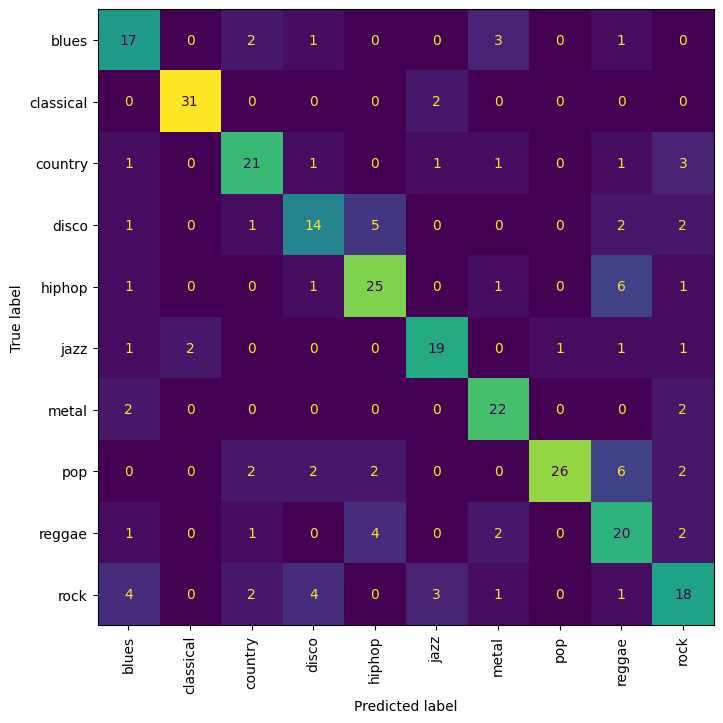

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(target_test,o_test), 
        display_labels=sorted(labels.keys()),
    ).plot(
        ax=ax, 
        xticks_rotation='vertical', 
        include_values=True, 
        cmap='viridis',  
        colorbar=False,
    )
# plt.show()

---